In [ ]:
from IPython.display import clear_output
!pip install paddle-quantum
!pip install qiskit
!pip install qiskit_dynamics
# !pip install qiskit-experiments
clear_output()

In [ ]:
import qiskit
import numpy as np
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit import pulse, QuantumCircuit,circuit,transpile
from qiskit.pulse import library, Schedule,GaussianSquare, ControlChannel, Play, Drag,DriveChannel,Delay,DriveChannel, SymbolicPulse, ShiftPhase
from qiskit.visualization.pulse_v2 import draw, IQXSimple,IQXDebugging
from qiskit.compiler import assemble, schedule
from qiskit import IBMQ
import copy
from qiskit.pulse import library
from qiskit.visualization.pulse_v2 import draw
from qiskit.providers.fake_provider import *
from qiskit.pulse import transforms
from qiskit.pulse.transforms import block_to_schedule
from typing import List, Tuple, Iterable, Union, Dict, Callable, Set, Optional, Any
from qiskit.pulse.instructions import Instruction
from qiskit.compiler import assemble, schedule
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.providers.aer import PulseSimulator
from qiskit_dynamics import Solver, DynamicsBackend
import random
import decimal
import numpy as np
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
import pickle
import qiskit.quantum_info as qi
from paddle_quantum.visual import plot_state_in_bloch_sphere

In [ ]:
backend = FakeQuito()

Save Data

Calculate Entanglement Capability

In [ ]:
num_sample = 500

In [ ]:
reload_file = open('3qHEfixedampentlist.pickle','rb')
ent_list = pickle.load(reload_file)
reload_file.close()

In [ ]:
Ent = sum(ent_list)/num_sample
print("Eantangling Capability for this PQC is: {0:.6f}".format(Ent))

Eantangling Capability for this PQC is: 0.331858+0.000000j


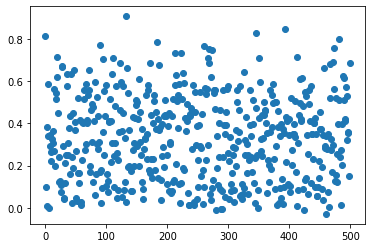

In [ ]:
import matplotlib.pyplot as plt

data = ent_list

real_data = [x.real for x in data]

plt.scatter(range(len(real_data)), real_data)
plt.show()

In [ ]:
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.qinfo import state_fidelity, partial_trace, purity
import warnings

# Haar distribution and K-L divergence

In [ ]:
num_qubit = 4     # the number of qubit
num_sample = 3000   # the number of sample

In [ ]:

reload_file = open('expr3layerDressed4qpulsefixedamp.pickle','rb')
outputs_rxcx = pickle.load(reload_file)
reload_file.close()

In [ ]:
from paddle_quantum.state import bell_state

In [ ]:
## 2 qubit in theory Ent = (N-2)/(N+1) = 0.4
num_qubit = 2        # the number of qubit
num_sample = 500    # the number of sample
ent_list = []

for _ in range(num_sample):
    # initialize QNN ansatz
    pq.set_backend('density_matrix')
    cir = Circuit(num_qubit)
    cir.rx(0)
    cir.rx(1)
    cir.cnot([0, 1])
    cir.rx(0)
    cir.rx(1)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    rho1 = partial_trace(rho, 2, 2, 1)
    rho2 = partial_trace(rho, 2, 2, 2)
    p = (purity(rho1) + purity(rho2))/num_qubit
    # Calculate Q
    Q =2*(1-p)
    ent_list.append(Q.numpy()[0])

Ent = sum(ent_list)/num_sample
print("Eantangling Capability for this PQC is: {0:.6f}".format(Ent))

Eantangling Capability for this PQC is: 0.495172


Calculate expressivity

In [ ]:
num_qubit = 4     # the number of qubit
num_sample = 3000    # the number of sample
reload_file = open('expr3layerDressed4qpulsefixedamp.pickle','rb')
outputs_universal2q = pickle.load(reload_file)
reload_file.close()


# 新段落

In [ ]:
reload_file = open('expr3layerDressed4qpulsefixedamp.pickle','rb')
outputs_mix = pickle.load(reload_file)
reload_file.close()

# 新段落

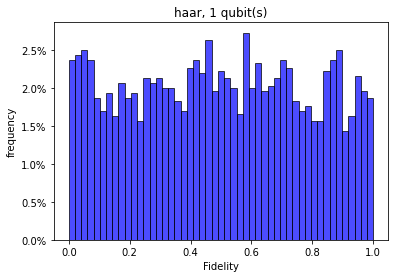

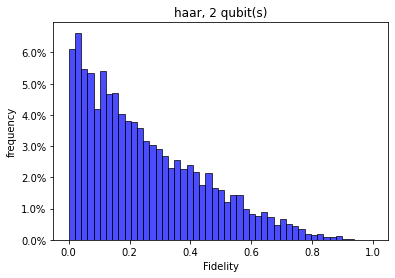

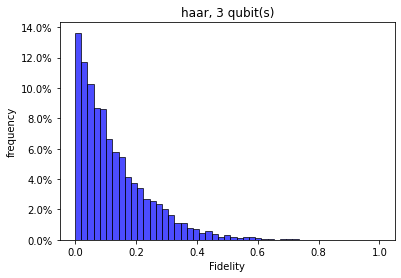

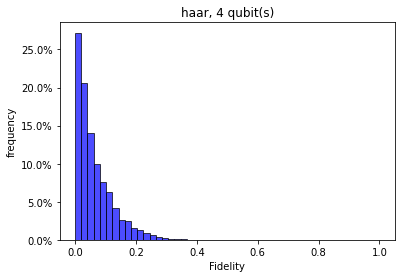

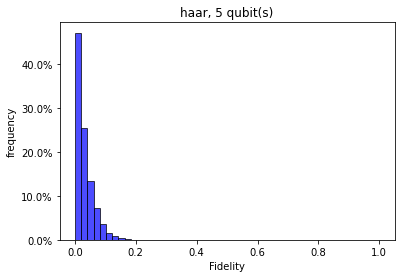

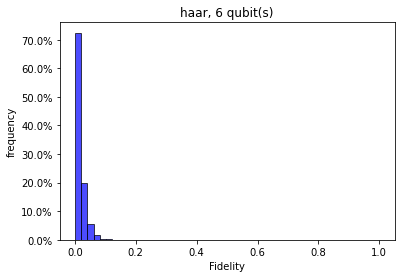

In [ ]:
from paddle_quantum.linalg import haar_unitary
from paddle_quantum.qinfo import state_fidelity
from paddle_quantum.state.common import to_state
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import integrate

# plot histgram
def plot_hist(data, num_bin, title_str):
    def to_percent(y, position):
        return str(np.around(y*100, decimals=2)) + '%'
    plt.hist(data, weights=[1./len(data)]*len(data), bins=np.linspace(0, 1, num=num_bin), facecolor="blue", edgecolor="black", alpha=0.7)
    plt.xlabel("Fidelity")
    plt.ylabel("frequency")
    plt.title(title_str)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()
    
    
# evaluate the probability distribution of F generated by a Haar random unitary
def p_F_haar(n, s, b=50, draw=False):
    f_list = list()
    # sampling
    for i in range(s):
        # sample a unitary
        u1 = haar_unitary(n)
        # the output of u1
        phi1 = u1[:,0]
        rho1 = to_state(np.outer(phi1, phi1.conj()))
        # sample a unitary
        u2 = haar_unitary(n)
        phi2 = u2[:,0]
        # the output of u2
        rho2 = to_state(np.outer(phi2, phi2.conj()))
        # compute fidality
        f_list.append(state_fidelity(rho1.numpy(), rho2.numpy())**2)

    f_list = np.array(f_list)

    # plot histgram
    if draw:
        title_str = "haar, %d qubit(s)" % num_qubit
        plot_hist(f_list, b, title_str)
    sample_distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)

    # compute a theoretical distribution
    theory_distribution = np.zeros_like(sample_distribution)
    for index in range(len(theory_distribution)):
        def p_continues(f):
            return (2 ** n - 1) * (1 - f) ** (2 ** n - 2)
        lower = 1/b*index
        upper = lower + 1/b
        theory_distribution[index], _ = integrate.quad(p_continues,lower,upper)
    return sample_distribution, theory_distribution


num_qubit = 1
p_haar_1qubit, theory_haar_1qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 2
p_haar_2qubit, theory_haar_2qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 3
p_haar_3qubit, theory_haar_3qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 4
p_haar_4qubit, theory_haar_4qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 5
p_haar_5qubit, theory_haar_5qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 6
p_haar_6qubit, theory_haar_6qubit = p_F_haar(num_qubit, num_sample, draw=True)

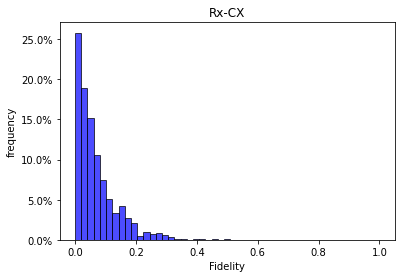

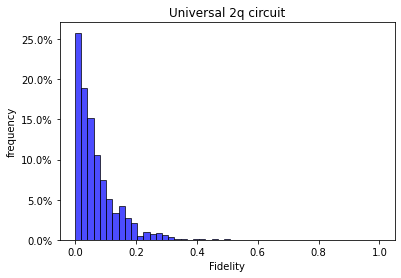

In [ ]:
# evaluate the probability distribution of F generated by QNNs
def p_F_qnn(n, s, g, b=50, draw=False):
    f_list = list()
    rho_sample = outputs_universal2q
    title_str = "Universal 2q circuit"
    if g == 2:
        rho_sample = outputs_mix
        title_str = "1d1c CR"
    elif g == 3:
        rho_sample = outputs_rxcx
        title_str = "Rx-CX"
    elif g == 5:
        rho_sample = outputs_duration
        title_str = "Duration"
    # elif g == 6:
    #     rho_sample = outputs_amp
    #     title_str = "Parametrized Pulse Amplitude"
    # elif g == 7:
    #     rho_sample = outputs_angle
    #     title_str = "Parametrized Pulse Angle"
    # elif g == 8:
    #     rho_sample = outputs_mix
    #     title_str = "Parametrized Pulse General"

    # use previously collected data to compute fidelity
    for index in range(int(s / 2)):
        rho1 = rho_sample[index]
        rho2 = rho_sample[index+int(num_sample / 2)]
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    
    # plot histgram
    if draw:
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution
    
    
num_qubit = 1
p_3 = p_F_qnn(num_qubit, num_sample, 3, draw=True)
p_4 = p_F_qnn(num_qubit, num_sample, 4, draw=True)
#p_pulse = p_F_qnn(num_qubit, num_sample, 2, draw=True)

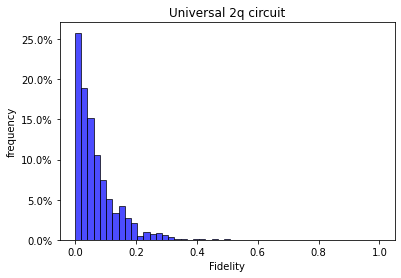

In [ ]:
p_1 = p_F_qnn(num_qubit, num_sample, 1, draw=True)

In [ ]:
# evaluate the probability distribution of F generated by QNNs
def p_F_qnnpulse(n, s, g, b=50, draw=False):
    f_list = list()
    rho_sample = outputs_universal2q
    title_str = "Universal 2q circuit"
    if g == 2:
        rho_sample = outputs_mix
        title_str = "1d1c CR"
    elif g == 3:
        rho_sample = outputs_rxcx
        title_str = "Rx-CX"
    elif g == 4:
        rho_sample = outputs_zzry
        title_str = "ZZ-Ry"
    elif g == 5:
        rho_sample = outputs_duration
        title_str = "Duration"
    # elif g == 6:
    #     rho_sample = outputs_amp
    #     title_str = "Parametrized Pulse Amplitude"
    # elif g == 7:
    #     rho_sample = outputs_angle
    #     title_str = "Parametrized Pulse Angle"
    # elif g == 8:
    #     rho_sample = outputs_mix
    #     title_str = "Parametrized Pulse General"

    # use previously collected data to compute fidelity
    for index in range(int(s / 2)):
        rho1 = rho_sample[index]
        rho2 = rho_sample[index+int(num_sample / 2)]
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    
    # plot histgram
    if draw:
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution

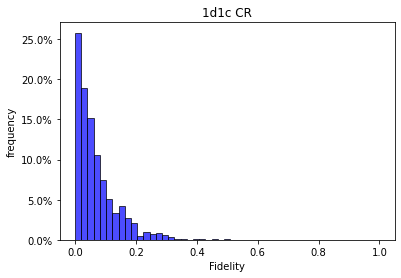

In [ ]:
p_dressedpulse = p_F_qnnpulse(num_qubit, num_sample, 2, draw=True)

In [ ]:
from scipy.stats import entropy
# calcutale relative entropy (K-L divergence)
expr_dressedpulse = entropy(p_dressedpulse, theory_haar_4qubit)
expr_2 = entropy(p_3, theory_haar_2qubit)
expr_1 = entropy(p_1, theory_haar_2qubit)

In [ ]:
expr_dressedpulse

0.01856833610691086

In [ ]:
expr_2

0.7954988651735888